Bird EDA

Library


In [ ]:
import pandas as pd
import seaborn as sns
import os

import pandas as pd
pd.options.mode.chained_assignment = None # avoids assignment warning
import numpy as np
import random
from glob import glob
from tqdm import tqdm
tqdm.pandas()  # enable progress bars in pandas operations
import gc

import sklearn
import json

# Import for visualization
import matplotlib as mpl
#cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt
import librosa.display as lid
import IPython.display as ipd
# import cv2
# WandB for experiment tracking
# import wandb
import ast
import networkx as nx
from collections import Counter

import torchaudio
import plotly.express as px
from IPython.display import Audio
from shapely.geometry import Point

import plotly.express as px
SAMPLE_RATE = 32000

Data loading

In [3]:
path = 'F:/Desktop/BU/MA679/Final/birdclef-2025'
os.listdir('F:/Desktop/BU/MA679/Final/birdclef-2025')
AUDIO_DIR = path + "/train_audio"
train_meta = pd.read_csv(path +'/train.csv')
# test_data = pd.read_csv(path+'test.csv')
ebird_data = pd.read_csv('taxonomy.csv')
# samp_subm = pd.read_csv('sample_submission.csv')

# with open(path+'scored_birds.json') as f:
    # scored_birds = json.load(f)
# print(AUDIO_DIR)

Functions

In [4]:
def read_ogg_file(path, file):
    """ Read ogg audio file and return numpay array and samplerate"""
    
    data, samplerate = sf.read(path+file)
    return data, samplerate


def plot_audio_file(data, samplerate):
    """ Plot the audio data"""
    
    sr = samplerate
    fig = plt.figure(figsize=(8, 4))
    x = range(len(data))
    y = data
    plt.plot(x, y)
    plt.plot(x, y, color='red')
    plt.legend(loc='upper center')
    plt.grid()
    
    
def plot_spectrogram(data, samplerate):
    """ Plot spectrogram with mel scaling """
    
    sr = samplerate
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

In [5]:
train_meta.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [6]:
print('Number of subfolders/species:', len(os.listdir(path+'/train_audio')))

Number of subfolders/species: 206


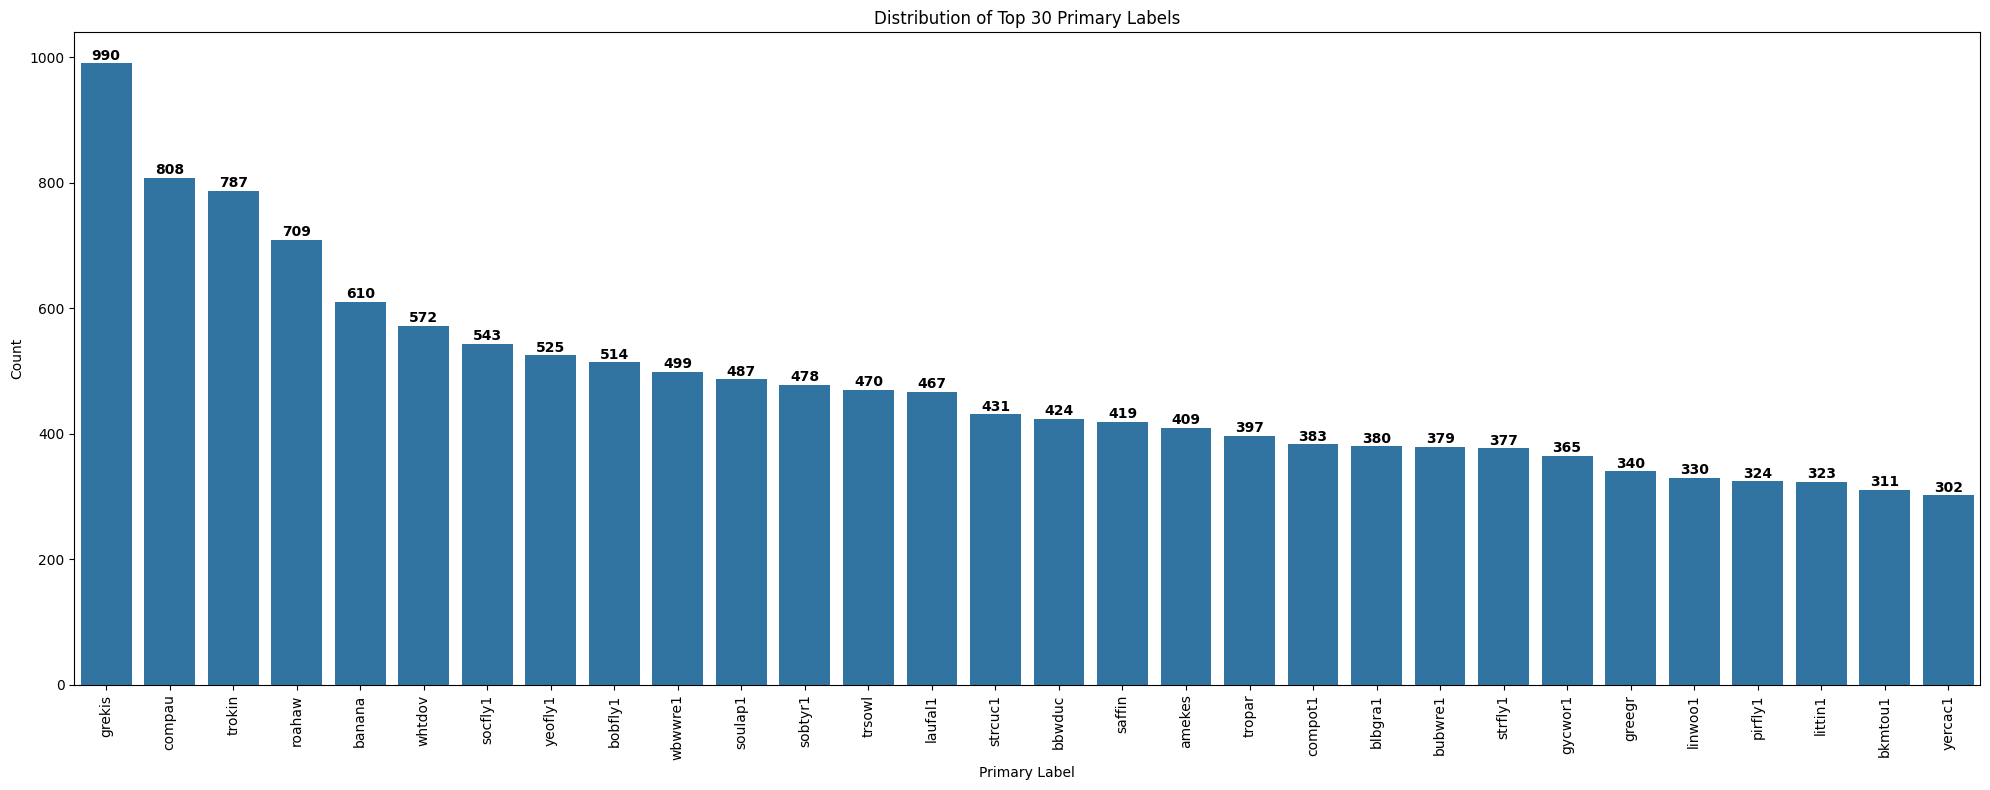

In [ ]:
# Load your CSV file
train_meta = pd.read_csv("train.csv")

# Count primary labels
primary_label_counts = train_meta['primary_label'].value_counts()
top_30 = primary_label_counts[:30]

# Plot bar chart with annotations
plt.figure(figsize=(20, 8))
ax = sns.barplot(x=top_30.index, y=top_30.values)

# Annotate text on top of bars
for i, value in enumerate(top_30.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribution of Top 30 Primary Labels')
plt.xticks(rotation=90)
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Taxnomy

Distribution of classes:
class_name
Aves        146
Amphibia     34
Insecta      17
Mammalia      9
Name: count, dtype: int64


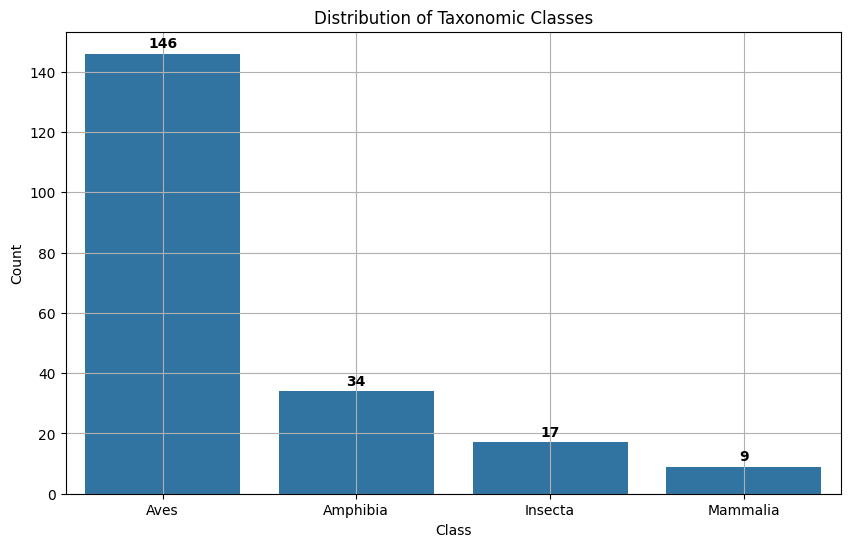

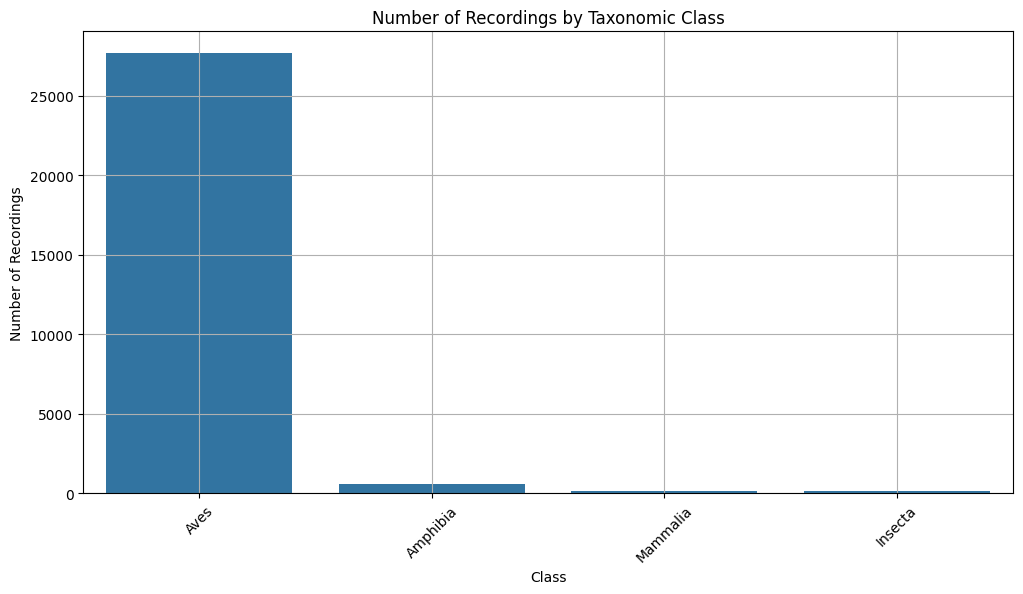

In [61]:
# Analyze class_name distribution in taxonomy
class_counts = ebird_data['class_name'].value_counts()
print("Distribution of classes:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
for i, value in enumerate(class_counts.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribution of Taxonomic Classes')
plt.xticks(rotation=0)
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()
# Merge train data with taxonomy for further analysis
train_with_taxonomy = pd.merge(train_meta, ebird_data, on='primary_label', how='left')

# Check for any missing matches
missing_taxonomy = train_with_taxonomy[train_with_taxonomy['class_name'].isna()]
if len(missing_taxonomy) > 0:
    print(f"Warning: {len(missing_taxonomy)} training samples don't have matching taxonomy entries")
    print(missing_taxonomy['primary_label'].unique())

# Analyze recordings by taxonomic class
class_recording_counts = train_with_taxonomy['class_name'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_recording_counts.index, y=class_recording_counts.values)
plt.title('Number of Recordings by Taxonomic Class')
plt.xticks(rotation=45)
plt.xlabel('Class')
plt.ylabel('Number of Recordings')
plt.grid(True)
plt.show()


secondary_labels vs primary labels

Recordings with at least one secondary label: 28539
Recordings with different secondary labels: 28539
Percentage of different secondary labels: 99.91%


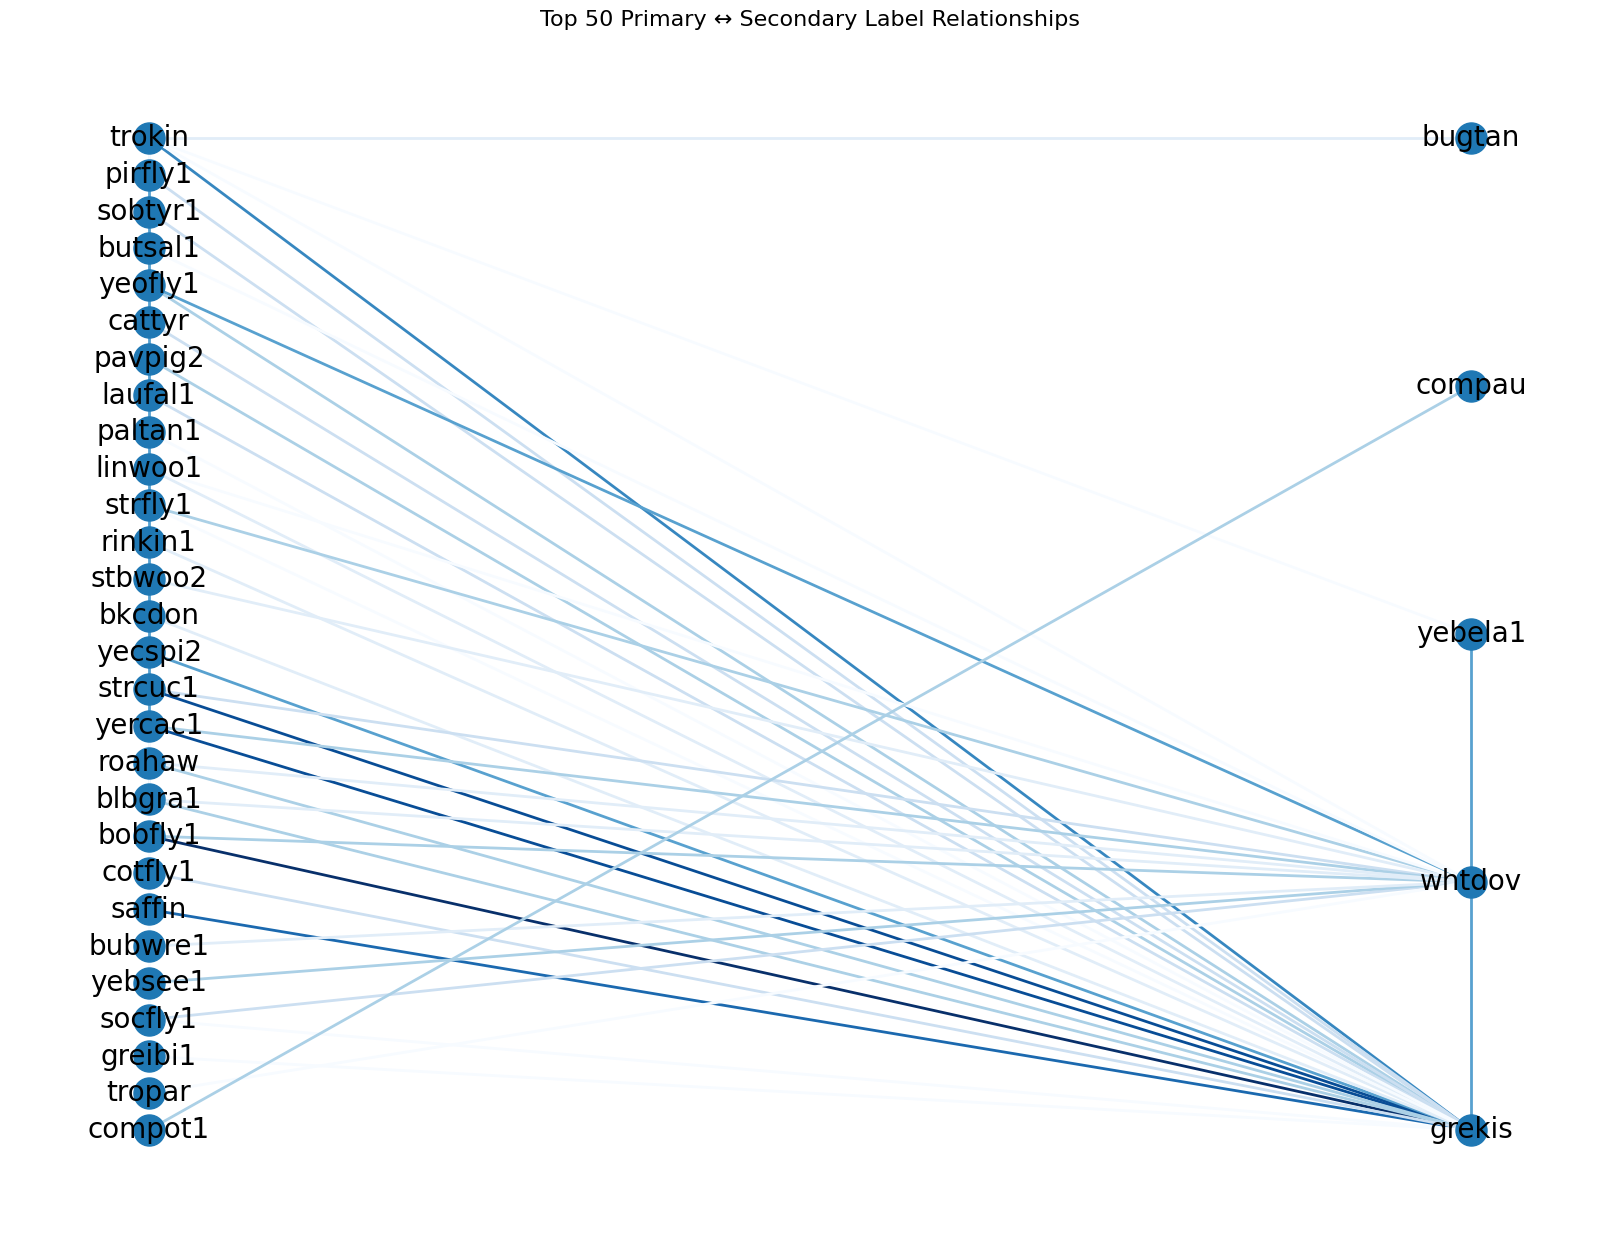

<Figure size 1400x600 with 0 Axes>

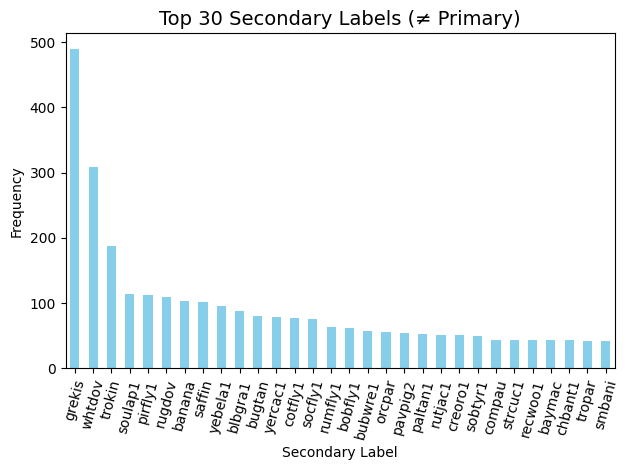

In [47]:
train_df = train_meta.copy
# Load metadata
train_df = pd.read_csv('train.csv')  # Change path if needed

# Parse secondary labels (convert from string to list)
def parse_secondary_labels(label_str):
    if pd.isna(label_str):
        return []
    try:
        return ast.literal_eval(label_str)
    except:
        return []

train_df['parsed_secondary_labels'] = train_df['secondary_labels'].apply(parse_secondary_labels)

# ----------------------------
# 1. Compare primary vs. secondary labels
# ----------------------------

def has_different_secondary(row):
    return any(label != row['primary_label'] for label in row['parsed_secondary_labels'])

train_df['has_diff_secondary'] = train_df.apply(has_different_secondary, axis=1)

# Summary stats
total_with_secondary = (train_df['parsed_secondary_labels'].apply(len) > 0).sum()
diff_secondary = train_df['has_diff_secondary'].sum()

print(f"Recordings with at least one secondary label: {total_with_secondary}")
print(f"Recordings with different secondary labels: {diff_secondary}")
print(f"Percentage of different secondary labels: {diff_secondary / len(train_df) * 100:.2f}%")

# ----------------------------
# 2. Create bipartite graph: Primary ↔ Secondary
# ----------------------------

# Build edge list
edges = []
for _, row in train_df.iterrows():
    primary = row['primary_label']
    for secondary in row['parsed_secondary_labels']:
        if secondary != primary and secondary != '':
            edges.append((primary, secondary))

# Count frequencies of edges
edge_counter = Counter(edges)
top_edges = edge_counter.most_common(50)  # Limit to top 50 for readability

# Build bipartite graph
G = nx.Graph()
for (primary, secondary), weight in top_edges:
    G.add_node(primary, bipartite=0)
    G.add_node(secondary, bipartite=1)
    G.add_edge(primary, secondary, weight=weight)

# Layout for bipartite graph
top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
pos = nx.bipartite_layout(G, top_nodes)

# Plot
plt.figure(figsize=(16, 12))
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    font_size=20,  # Increased font size for better readability
    edge_color=edge_weights,
    edge_cmap=plt.cm.Blues,
    width=2.0
)
plt.title("Top 50 Primary ↔ Secondary Label Relationships", fontsize=16)
plt.show()
def parse_labels(label_str):
    if pd.isna(label_str):
        return []
    try:
        return ast.literal_eval(label_str)
    except:
        return []
train_df['parsed_secondary'] = train_df['secondary_labels'].apply(parse_labels)


# Count secondary labels that are different from primary
different_secondary = []
for _, row in train_df.iterrows():
    prim = row['primary_label']
    for sec in row['parsed_secondary']:
        if sec and sec != prim:
            different_secondary.append(sec)

# Count frequency
sec_freq = Counter(different_secondary)

# Convert to DataFrame
sec_freq_df = pd.DataFrame.from_dict(sec_freq, orient='index', columns=['count']).sort_values('count', ascending=False)

# Plot top 30 secondary labels (different from primary)
plt.figure(figsize=(14, 6))
sec_freq_df.head(30).plot(kind='bar', legend=False, color='skyblue')
plt.title("Top 30 Secondary Labels (≠ Primary)", fontsize=14)
plt.ylabel("Frequency")
plt.xlabel("Secondary Label")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


C:\Users\bsbfc\AppData\Local\Temp\ipykernel_7896\1472731157.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



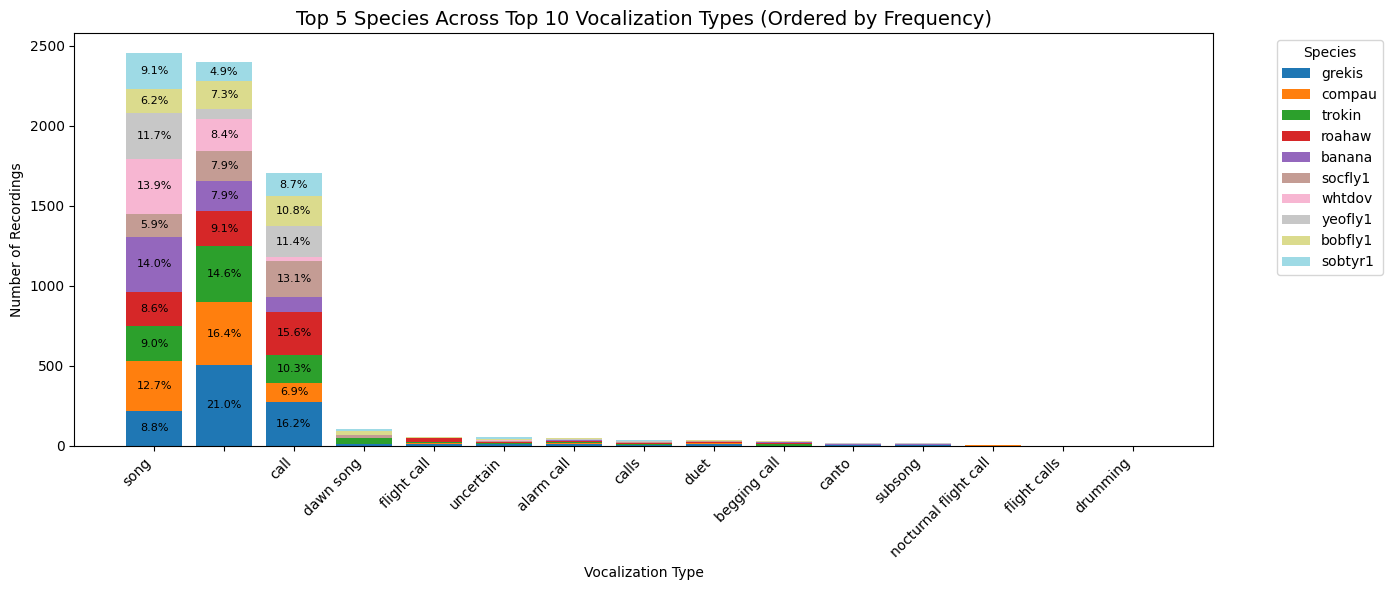

In [ ]:
# kernel reset
import pandas as pd
import matplotlib.pyplot as plt
import ast
from collections import Counter
import matplotlib.cm as cm

# Reload and reprocess the data
df = pd.read_csv("train.csv", usecols=['primary_label', 'type'])
df['parsed_type'] = df['type'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# Identify top 10 vocalization types
all_types = [t for sublist in df['parsed_type'] for t in sublist]
top_10_types = [t for t, _ in Counter(all_types).most_common(15)]

# Filter and reshape the data
df['filtered_type'] = df['parsed_type'].apply(lambda lst: [t for t in lst if t in top_10_types])
df_exploded = df.explode('filtered_type').dropna(subset=['filtered_type'])

# Aggregate by vocalization type and species
grouped = df_exploded.groupby(['filtered_type', 'primary_label']).size().unstack(fill_value=0)
top_species = grouped.sum().sort_values(ascending=False).head(10).index
grouped = grouped[top_species]

# Reorder by total count of vocalization type
grouped['total'] = grouped.sum(axis=1)
grouped = grouped.sort_values(by='total', ascending=False).drop(columns='total')

# Plot with count on y-axis and percent text
fig, ax = plt.subplots(figsize=(14, 6))
colors = cm.get_cmap('tab20', len(top_species)).colors
bottom = [0] * len(grouped)

for idx, species in enumerate(grouped.columns):
    counts = grouped[species].values
    bars = ax.bar(grouped.index, counts, bottom=bottom, label=species, color=colors[idx])
    for i, count in enumerate(counts):
        total = sum(grouped.iloc[i])
        if count > 100:  # Only show percent if significant
            percent = 100 * count / total
            ax.text(i, bottom[i] + count / 2, f"{percent:.1f}%", ha='center', va='center', fontsize=8)
        bottom[i] += count

ax.set_title("Top 5 Species Across Top 10 Vocalization Types (Ordered by Frequency)", fontsize=14)
ax.set_xlabel("Vocalization Type")
ax.set_ylabel("Number of Recordings")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Co - occurrence Matrix

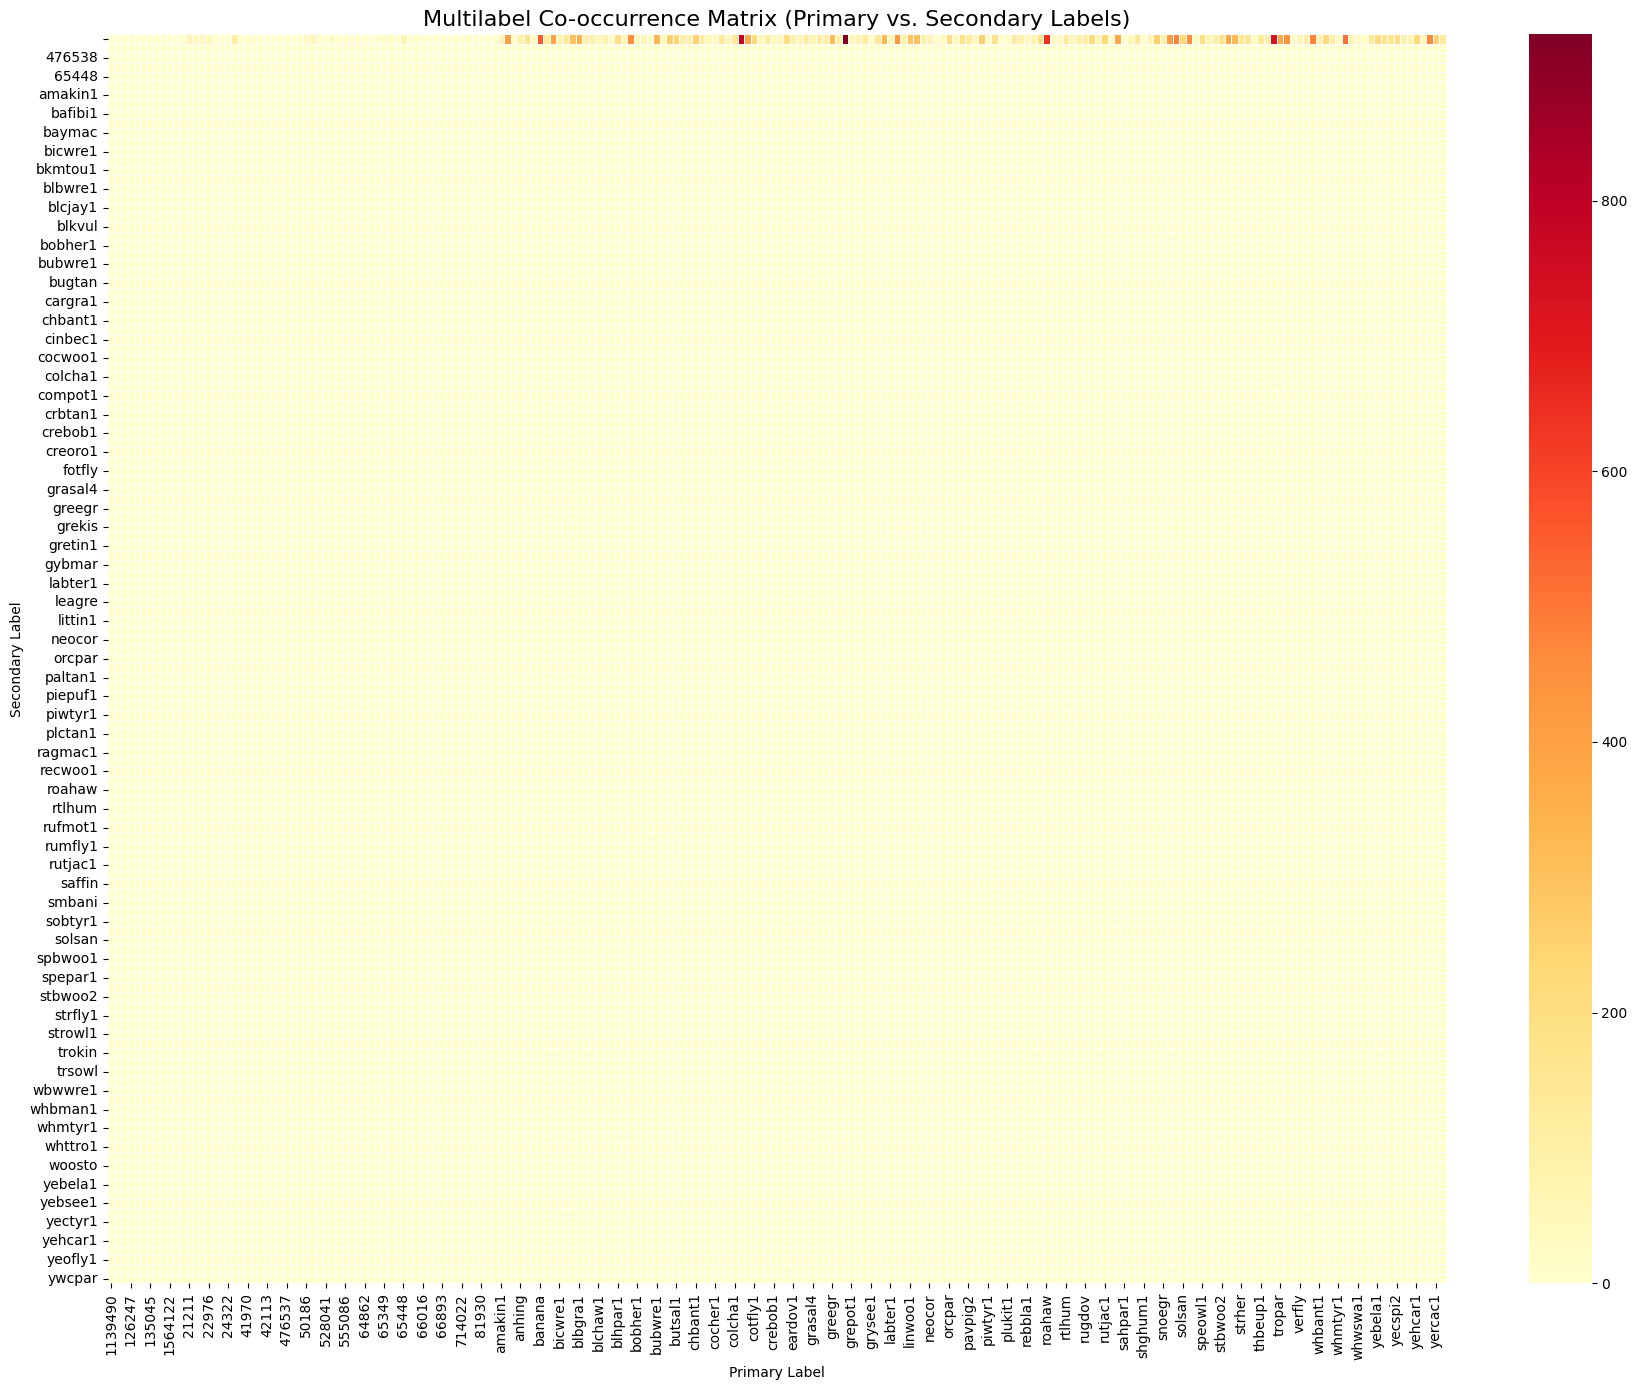

In [ ]:

# Load the CSV file
df = pd.read_csv("train.csv")

# Convert the stringified lists into actual Python lists
df["secondary_labels"] = df["secondary_labels"].apply(eval)

# Build co-occurrence dictionary
co_occurrence = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    primary = row["primary_label"]
    for secondary in row["secondary_labels"]:
        if secondary != primary:
            co_occurrence[primary][secondary] += 1

# Convert dictionary to DataFrame
co_matrix = pd.DataFrame(co_occurrence).fillna(0).astype(int)

# Sort rows and columns
co_matrix = co_matrix.reindex(sorted(co_matrix.index))
co_matrix = co_matrix[sorted(co_matrix.columns)]

# Plot as a heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(co_matrix, cmap="YlOrRd", linewidths=0.5)
plt.title("Multilabel Co-occurrence Matrix (Primary vs. Secondary Labels)", fontsize=16)
plt.xlabel("Primary Label")
plt.ylabel("Secondary Label")
plt.tight_layout()
plt.show()

Geographic plot

In [72]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'  

fig = px.scatter_mapbox(train_meta, lat='latitude', lon='longitude', color='primary_label', 
                        hover_name='primary_label', hover_data=['latitude', 'longitude'], 
                        title='Geographical Distribution of Bird Species',
                        zoom=1, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.show()


C:\Users\bsbfc\AppData\Local\Temp\ipykernel_7896\1205532861.py:6: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



Audio duration density

In [ ]:
def load_audio_file(file_path, sr=SAMPLE_RATE):
    """Load an audio file and return the signal."""
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return audio
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Get list of audio files
train_audio_files = []
for root, _, files in os.walk(AUDIO_DIR):
    for file in files:
        if file.endswith('.ogg'):
            train_audio_files.append(os.path.join(root, file))

print(f"Total number of training audio files: {len(train_audio_files)}")

# Sample a few random files for analysis
random.seed(42)
sample_audio_files = random.sample(train_audio_files, min(5, len(train_audio_files)))

# Load sample files
sample_audios = []
for file_path in sample_audio_files:
    audio = load_audio_file(file_path)
    if audio is not None:
        filename = os.path.basename(file_path)
        label = filename.split('_')[0]  # Assuming filename format starts with label
        sample_audios.append({
            'path': file_path,
            'audio': audio,
            'duration': len(audio) / SAMPLE_RATE,
            'filename': filename,
            'label': label
        })

print(f"Loaded {len(sample_audios)} sample audio files")
# Function to get audio duration
def get_audio_duration(file_path, sr=SAMPLE_RATE):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        return len(audio) / sr
    except Exception as e:
        return None

# Sample audio files for duration analysis (this can be slow, so we'll sample)
duration_sample_size = len(train_audio_files)
duration_sample_files = random.sample(train_audio_files, duration_sample_size)

# Get durations
print(f"Calculating durations for {duration_sample_size} files...")
durations = []
for file_path in tqdm(duration_sample_files):
    duration = get_audio_duration(file_path)
    if duration is not None:
        durations.append(duration)

# Plot duration distribution
plt.figure(figsize=(12, 6))
plt.hist(durations, bins=100)
plt.title('Distribution of Audio Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Duration statistics:")
print(f"Mean duration: {np.mean(durations):.2f} seconds")
print(f"Median duration: {np.median(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")
print(f"Max duration: {np.max(durations):.2f} seconds")

# Check for very short recordings (< 1s)
short_recordings = [d for d in durations if d < 1]
print(f"Very short recordings (<1s): {len(short_recordings)} ({len(short_recordings)/len(durations)*100:.2f}%)")

# Check for long recordings (> 60s)
long_recordings = [d for d in durations if d > 60]
print(f"Long recordings (>60s): {len(long_recordings)} ({len(long_recordings)/len(durations)*100:.2f}%)")

In [33]:
train_meta.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


Waveform and mel spectrom

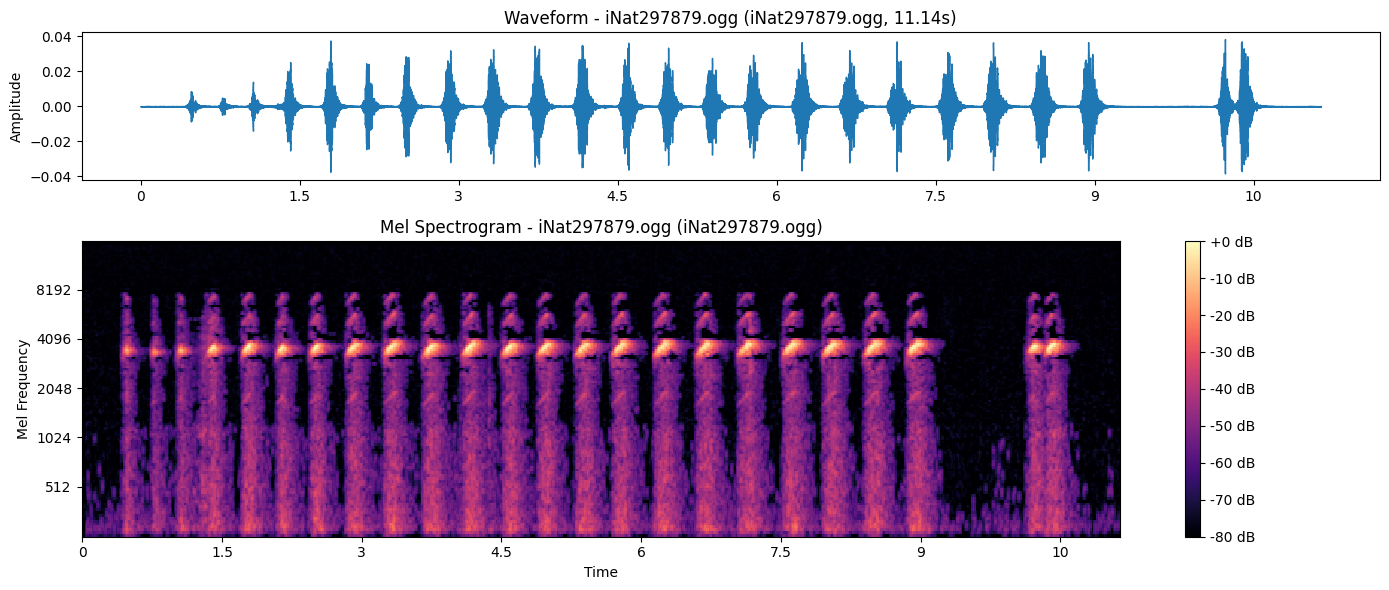

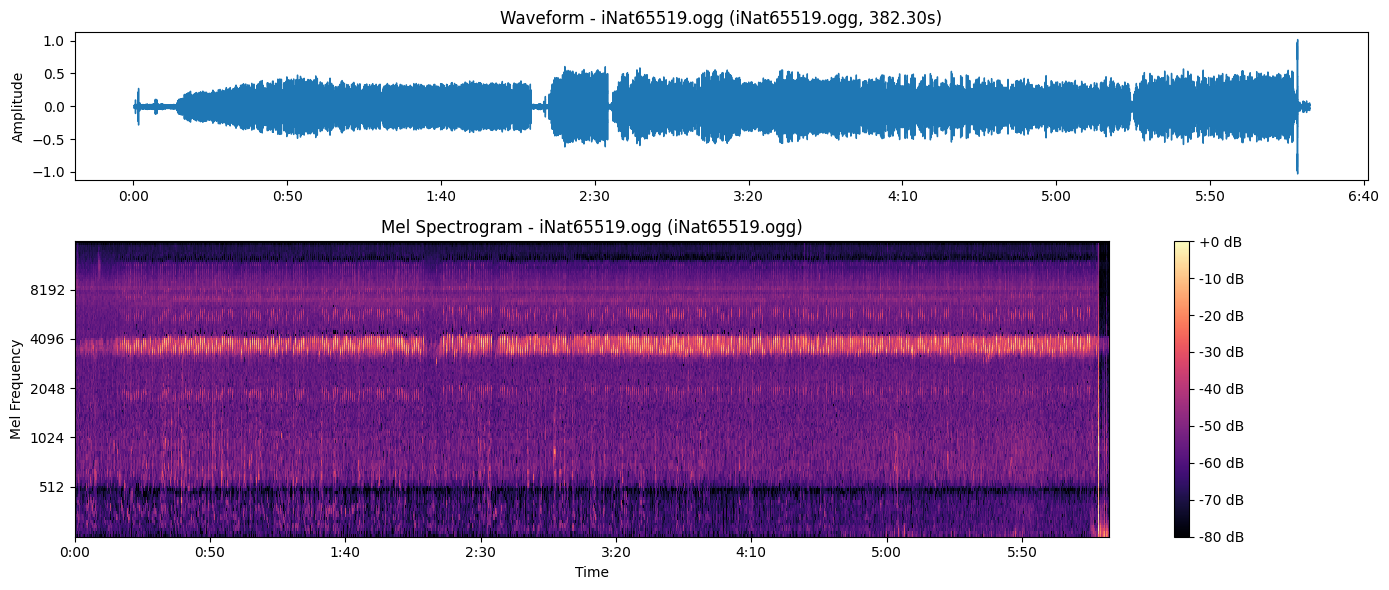

In [ ]:
# === Set up ===
SAMPLE_RATE = 32000
AUDIO_FOLDER = r'F:\Desktop\BU\MA679\Final\birdclef-2025\train_audio\21038'

# Helper function to load audio
def load_audio_file(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)
        return audio
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")
        return None

# === Load all audio files ===
sample_audios = []
for filename in os.listdir(AUDIO_FOLDER):
    if filename.endswith('.ogg') or filename.endswith('.wav'):
        file_path = os.path.join(AUDIO_FOLDER, filename)
        audio = load_audio_file(file_path)
        if audio is not None:
            label = filename.split('_')[0]  # Assumes label is before the first underscore
            sample_audios.append({
                'path': file_path,
                'audio': audio,
                'duration': len(audio) / SAMPLE_RATE,
                'filename': filename,
                'label': label
            })

# === Create mel spectrogram ===
def create_mel_spectrogram(audio, sr=SAMPLE_RATE, n_mels=128, fmin=20, fmax=16000):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# === Plot waveform and mel spectrogram ===
for sample in sample_audios:
    audio = sample['audio']
    filename = sample['filename']
    label = sample['label']
    duration = sample['duration']
    
    mel_spec = create_mel_spectrogram(audio)
    
    fig, axs = plt.subplots(2, 1, figsize=(14, 6), gridspec_kw={'height_ratios': [1, 2]})
    
    # Waveform
    librosa.display.waveshow(audio, sr=SAMPLE_RATE, ax=axs[0])
    axs[0].set_title(f"Waveform - {filename} ({label}, {duration:.2f}s)")
    axs[0].set_xlabel("")
    axs[0].set_ylabel("Amplitude")
    
    # Mel Spectrogram
    img = librosa.display.specshow(mel_spec, sr=SAMPLE_RATE, x_axis='time', y_axis='mel',
                                   fmin=20, fmax=16000, ax=axs[1])
    axs[1].set_title(f"Mel Spectrogram - {filename} ({label})")
    axs[1].set_ylabel("Mel Frequency")
    fig.colorbar(img, ax=axs[1], format="%+2.0f dB", orientation="vertical")
    
    plt.tight_layout()
    plt.show()
